In [33]:
import math
import random
import numpy as np
from itertools import product

from qiskit import *

# Importing standard Qiskit libraries
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

from qiskit.utils import QuantumInstance

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow import StateFn
from qiskit.opflow import Gradient
from qiskit.opflow import CircuitSampler
from qiskit.opflow.primitive_ops import MatrixOp

from qiskit.circuit import Parameter
from qiskit.circuit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import RealAmplitudes
from qiskit.circuit.library.standard_gates import CRYGate

from qiskit.algorithms.optimizers import SPSA
from qiskit.algorithms.optimizers import GradientDescent
from qiskit.algorithms.optimizers import ADAM

from qiskit.providers.aer.noise import NoiseModel

from qiskit.quantum_info import Statevector
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter

In [34]:
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2022-10-04 20:35:52,991: Credentials are already in use. The existing account in the session will be replaced.


In [35]:
def rand_numb(low_in,high_in):
    return np.random.uniform(low=low_in, high=np.nextafter(high_in, np.inf))

#just to keep the upper limit included in the random number generation. 

In [128]:
numLayer = 3
numQubit = 6
global iterations
global noisy

In [129]:
#Create unitaries here
unitary_param_1 = np.array([])
for i in range(0, 16):
    unitary_param_1 = np.append(unitary_param_1, np.array([rand_numb(0,2*np.pi)]))

#unitary_param_1 = [2.10501732, 5.11015318, 1.02860258, 4.19873724, 4.92982797, 0.34386221, 0.36480756, 0.03715926, 
#                   0.26142496, 3.83355082, 2.72581293, 4.00028864]

In [130]:
print(unitary_param_1)

[1.3790245  4.17622474 6.01173175 5.03689767 2.83950214 3.63379694
 1.79492919 3.68166349 5.33113359 6.12867267 1.51139027 5.52040628
 5.62948103 1.2400208  5.88508318 5.9874692 ]


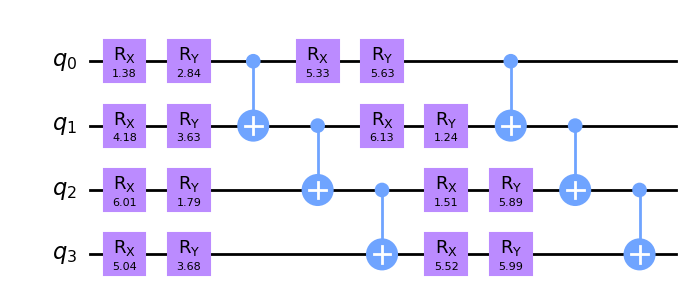

In [131]:
# First unitary
size = 4
layers = 2
state = QuantumCircuit(size)
for j in range(layers):
    for i in range(size):
        state.rx(unitary_param_1[j*size*2 + i], i)
        state.ry(unitary_param_1[j*2*size + i + size], i)

    for i in range(size-1):
        state.cx(i, i+1)

state.draw('mpl')

In [132]:
def createProver(numQubit, numLayer):
    numparam = numQubit*numLayer*2
    prover = QuantumCircuit(numQubit)
    param_vector = ParameterVector("params", numparam)
    
    for j in range(numLayer):
        for i in range(numQubit):
            prover.rx(param_vector[j*2*numQubit + i], i)
            prover.ry(param_vector[j*2*numQubit + i + numQubit], i)

        for i in range(numQubit-1):
            prover.cx(i, i+1)
            
    return prover

In [133]:
def createEqSuperpos3E():
    temp = QuantumCircuit(3)
    temp.ry(2*np.arctan(1/np.sqrt(2)), 0)
    temp.x(0)
    temp.ch(0, 1)
    temp.x(0)
    temp.h(2)
    return temp

In [160]:
def createWernerState(F):
    theta1 = 2*np.arccos(np.sqrt(0.667*(1-F)))
    theta2 = 2*np.arctan(np.sqrt(3*F/(1-F)))
    
    state = QuantumCircuit(4)
    state.ry(theta1, 2)
    state.append(CRYGate(theta2), [2, 3])
    state.x(2)
    state.ch(2, 3)
    state.x(2)
    
    state.h(0)
    state.cx(0, 1)
    
    state.cz(0, 3)
    state.cx(2, 0)
    
    return state

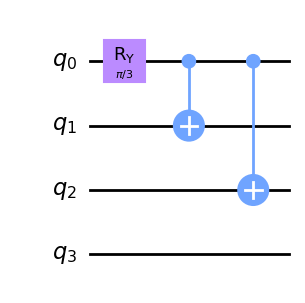

In [161]:
qcTest = QuantumCircuit(4)
qcTest.ry(np.pi/3, 0)
qcTest.cx(0, 1)
qcTest.cx(0, 2)
qcTest.draw('mpl')

In [162]:
def createQuantumCircuit(state, numQubit, numLayer):
    circ = QuantumCircuit(11)
    #Create Quantum Circuit here
    
    superPosCircuit = createEqSuperpos3E()
    circ.append(superPosCircuit, [0, 1, 2])

    circ.append(state, [3, 4, 5, 6])
    
    prover = createProver(numQubit, numLayer)
    circ.append(prover, [5, 6, 7, 8, 9, 10])
    
    circ.cswap(2, 5, 6)
    circ.cswap(2, 9, 10)
    
    circ.cswap(1, 4, 6)
    circ.cswap(1, 8, 10)
    
    circ.cswap(0, 4, 5)
    circ.cswap(0, 8, 9)
    
    circ.append(superPosCircuit.inverse(), [0, 1, 2])
    
    return circ

/opt/anaconda3/envs/qiskit/lib/python3.9/site-packages/qiskit/circuit/tools/pi_check.py:55: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = expr.expr_free_symbols


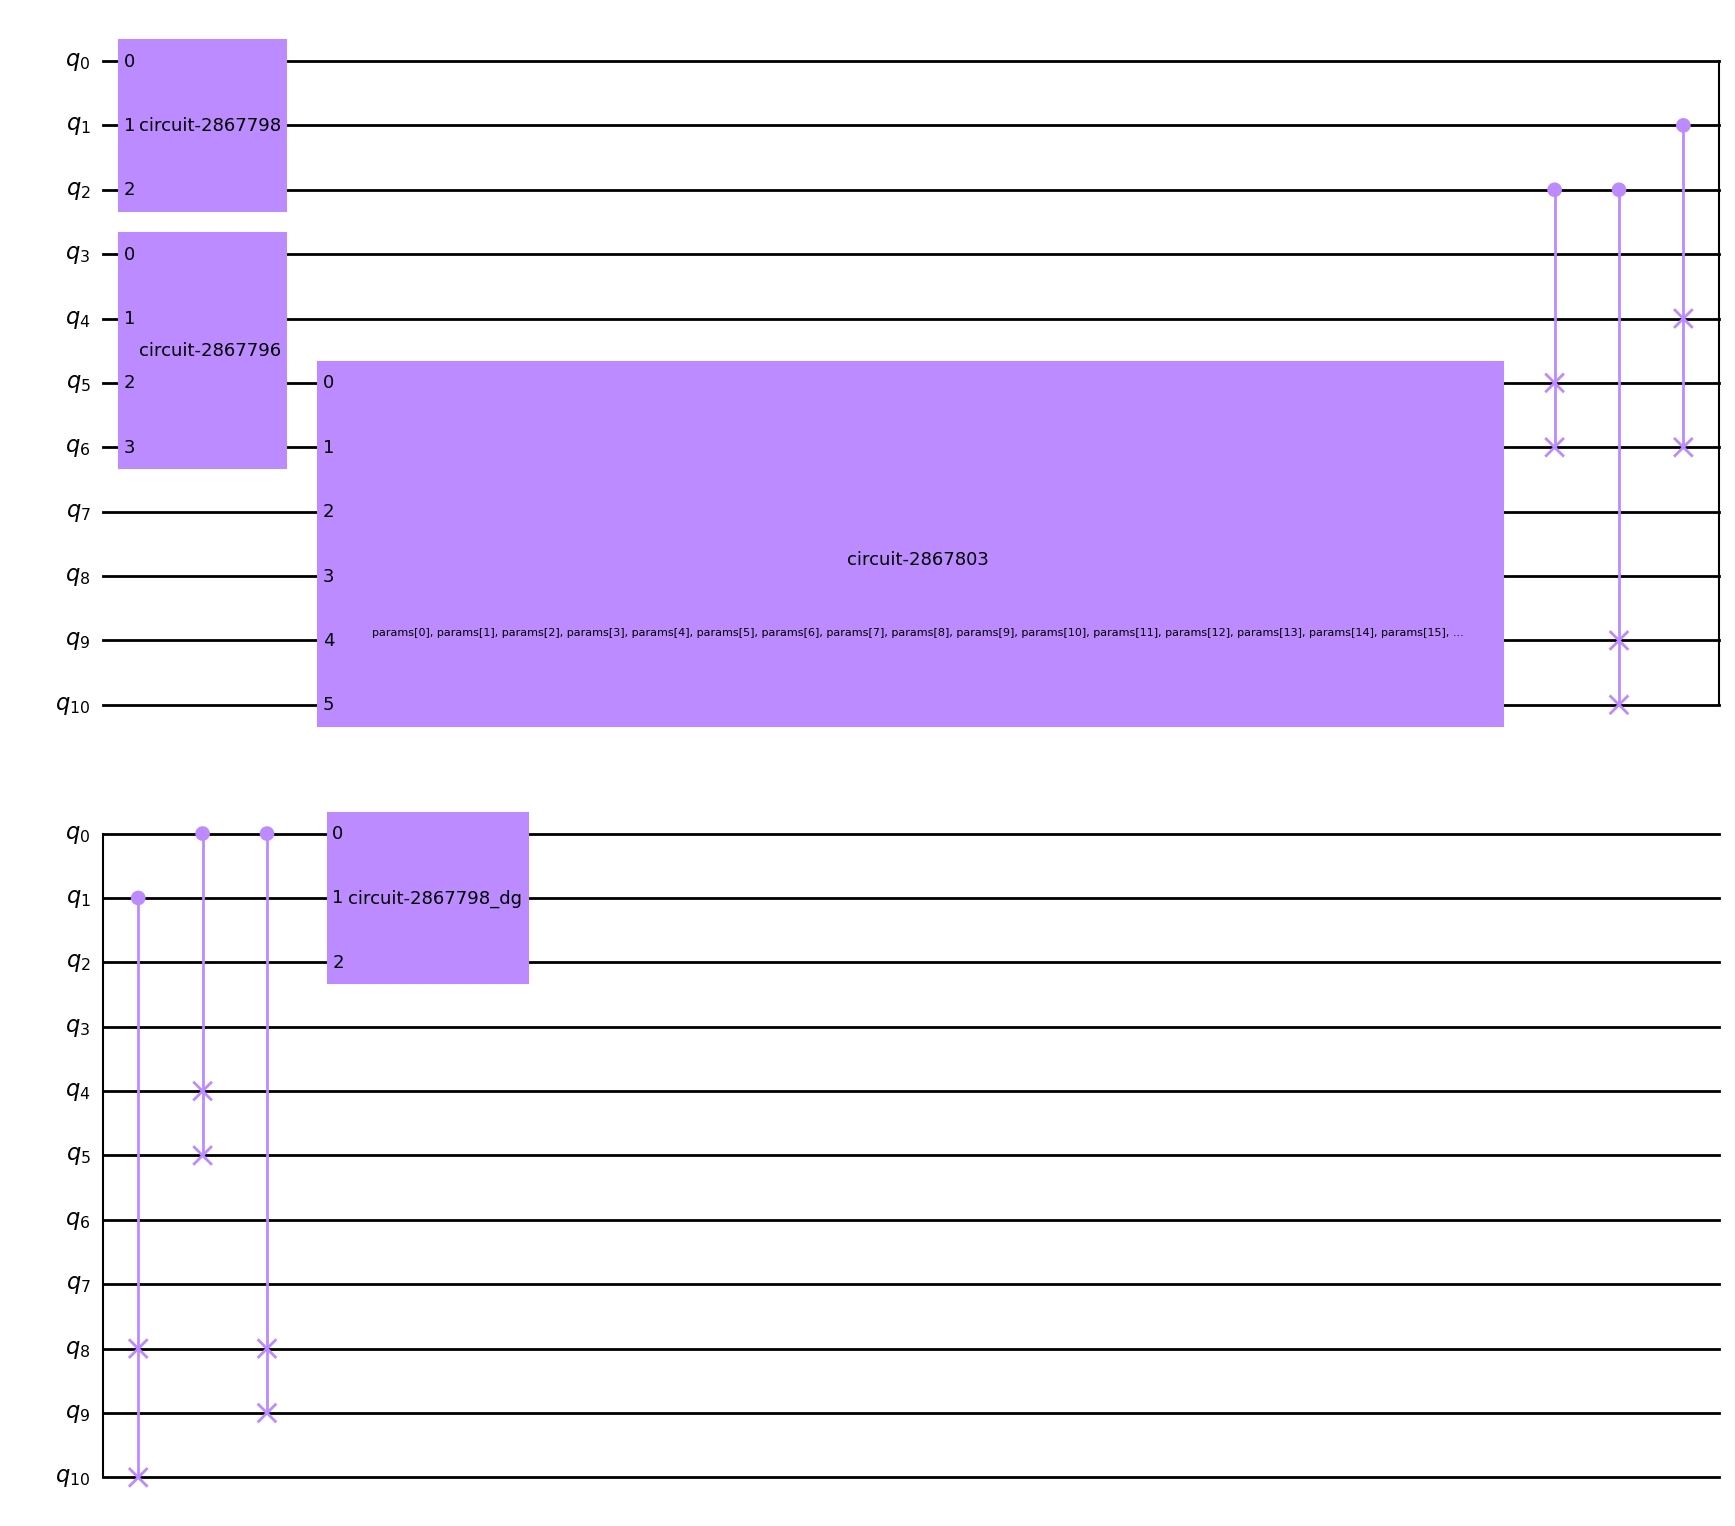

In [163]:
qCirc = createQuantumCircuit(createWernerState(0.90), numQubit, numLayer)
qCirc.draw('mpl')

In [164]:
#use if noiseless
noiseless_backend = Aer.get_backend('statevector_simulator')
noiseless_q_instance = QuantumInstance(noiseless_backend)
noiseless_sampler = CircuitSampler(noiseless_q_instance)

In [165]:
#Use if noisy
provider = IBMQ.get_provider(hub="ibm-q-research", group="louisiana-st-uni-1", project="main")
noisy_backend = Aer.get_backend("qasm_simulator")
device = provider.get_backend("ibmq_jakarta")
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device.properties())
noisy_q_instance = QuantumInstance(backend=noisy_backend, 
                           shots=8192, 
                           noise_model=noise_model, 
                           coupling_map=coupling_map,
                           measurement_error_mitigation_cls=CompleteMeasFitter,
                           cals_matrix_refresh_period=30)
noisy_sampler = CircuitSampler(noisy_q_instance)

In [166]:
#Create Hamiltonian here
hamiltonian = I^I^I^I^I^I^I^I^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))^MatrixOp(np.array([[1, 0], [0, 0]]))

In [167]:
def costf(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    
    if noisy:
        result = noisy_sampler.convert(expectation, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(expectation, params=value_dict).eval()  
    
    return -1*np.real(result)

In [168]:
def gradient(params):
    expectation = StateFn(hamiltonian, is_measurement=True).compose(StateFn(qCirc))
    value_dict = dict(zip(qCirc.parameters, params))
    gradient = Gradient().convert(expectation)
    
    if noisy:
        result = noisy_sampler.convert(gradient, params=value_dict).eval()  
    else:
        result = noiseless_sampler.convert(gradient, params=value_dict).eval()  
    
    return -1*np.real(result)

In [169]:
print(qCirc.parameters)

ParameterView([ParameterVectorElement(params[0]), ParameterVectorElement(params[1]), ParameterVectorElement(params[2]), ParameterVectorElement(params[3]), ParameterVectorElement(params[4]), ParameterVectorElement(params[5]), ParameterVectorElement(params[6]), ParameterVectorElement(params[7]), ParameterVectorElement(params[8]), ParameterVectorElement(params[9]), ParameterVectorElement(params[10]), ParameterVectorElement(params[11]), ParameterVectorElement(params[12]), ParameterVectorElement(params[13]), ParameterVectorElement(params[14]), ParameterVectorElement(params[15]), ParameterVectorElement(params[16]), ParameterVectorElement(params[17]), ParameterVectorElement(params[18]), ParameterVectorElement(params[19]), ParameterVectorElement(params[20]), ParameterVectorElement(params[21]), ParameterVectorElement(params[22]), ParameterVectorElement(params[23]), ParameterVectorElement(params[24]), ParameterVectorElement(params[25]), ParameterVectorElement(params[26]), ParameterVectorElement(

In [170]:
def autospsa_callback(nfev, x, fx, stepsize, accepted = False):
    if (noisy == True):
        noisy_loss.append(-1*fx)
    else:
        noiseless_loss.append(-1*fx)
    print("Loss Value : ", -1*fx, str(nfev/3)+"%")

In [171]:
numParam = 2*numQubit*numLayer
noisy = False
paramProver = []
for i in range(0, numParam):
    paramProver = np.append(paramProver, np.array([rand_numb(0,2*np.pi)]))
print(paramProver)

print("Initial Cost : ", -1*costf(paramProver))

[2.26748596 1.5207414  3.98611023 3.22812083 4.58696893 3.49753987
 5.84371579 1.68777917 2.14519582 2.70799813 1.29041249 2.76916747
 2.47312461 0.92575584 2.69727403 5.46458923 1.32232677 4.55921533
 3.02141201 5.51818205 2.46687568 0.98072673 1.91423185 3.7870981
 6.10315462 4.37130522 4.66901669 0.21136616 1.71222659 0.47360305
 6.12191879 1.32548106 2.88177904 4.12620641 0.6811632  3.27073142]
Initial Cost :  0.2572487224394669


In [172]:
true_value = 0.9162086460967217

In [173]:
noisy = False
noiseless_loss = []
noiselessParam = np.copy(paramProver)
print("Initial Cost : ", -1*costf(noiselessParam))
autospsa = SPSA(maxiter=500, learning_rate=0.30, perturbation=0.1, callback=autospsa_callback)
x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noiselessParam)

Initial Cost :  0.2572487224394669
Loss Value :  0.25834554198069787 1.0%
Loss Value :  0.2650923044523974 2.0%
Loss Value :  0.2809814690650551 3.0%
Loss Value :  0.28112685352821554 4.0%
Loss Value :  0.2902860655994576 5.0%
Loss Value :  0.2951282437878469 6.0%
Loss Value :  0.30388338063995335 7.0%
Loss Value :  0.30390799789718315 8.0%
Loss Value :  0.3077533474579236 9.0%
Loss Value :  0.31896378751437027 10.0%
Loss Value :  0.31991991474993575 11.0%
Loss Value :  0.3224469853385919 12.0%
Loss Value :  0.3238698045698233 13.0%
Loss Value :  0.3360493662968504 14.0%
Loss Value :  0.3424463126683865 15.0%
Loss Value :  0.3426029107089378 16.0%
Loss Value :  0.3647658565340528 17.0%
Loss Value :  0.3694397385322089 18.0%
Loss Value :  0.3909415096775888 19.0%
Loss Value :  0.39886885787174164 20.0%
Loss Value :  0.40211208116016983 21.0%
Loss Value :  0.40217343120121585 22.0%
Loss Value :  0.4115293039482377 23.0%
Loss Value :  0.4115327584253586 24.0%
Loss Value :  0.4125529344471

Loss Value :  0.8028589130488974 208.0%
Loss Value :  0.8044343172326986 209.0%
Loss Value :  0.8044770245020876 210.0%
Loss Value :  0.8070083547029734 211.0%
Loss Value :  0.8071091074487062 212.0%
Loss Value :  0.8097473944861432 213.0%
Loss Value :  0.8097472323792528 214.0%
Loss Value :  0.810469408903635 215.0%
Loss Value :  0.8124636200923216 216.0%
Loss Value :  0.8124561139429253 217.0%
Loss Value :  0.8125399061998256 218.0%
Loss Value :  0.816031437881259 219.0%
Loss Value :  0.8153675921667851 220.0%
Loss Value :  0.8156554401999373 221.0%
Loss Value :  0.8159183911990766 222.0%
Loss Value :  0.8159138950102667 223.0%
Loss Value :  0.8159142358450138 224.0%
Loss Value :  0.8159521121034304 225.0%
Loss Value :  0.8187657547357271 226.0%
Loss Value :  0.817397246935313 227.0%
Loss Value :  0.8185188003709388 228.0%
Loss Value :  0.8194618355653649 229.0%
Loss Value :  0.8207729242405695 230.0%
Loss Value :  0.8208721438844994 231.0%
Loss Value :  0.8218838092834695 232.0%
Los

Loss Value :  0.8471334737719014 414.0%
Loss Value :  0.8472261886534638 415.0%
Loss Value :  0.8467833478804561 416.0%
Loss Value :  0.8468515985579533 417.0%
Loss Value :  0.8468148204844421 418.0%
Loss Value :  0.8469057766437134 419.0%
Loss Value :  0.8468779021773654 420.0%
Loss Value :  0.8469113035622802 421.0%
Loss Value :  0.8464875307311748 422.0%
Loss Value :  0.8466310623049094 423.0%
Loss Value :  0.8471078914327862 424.0%
Loss Value :  0.8471026980537196 425.0%
Loss Value :  0.8473619925871129 426.0%
Loss Value :  0.8472726065562659 427.0%
Loss Value :  0.8459899019394399 428.0%
Loss Value :  0.8459991020001023 429.0%
Loss Value :  0.8459301533747062 430.0%
Loss Value :  0.8460150859470383 431.0%
Loss Value :  0.8453742708920984 432.0%
Loss Value :  0.8453715326783231 433.0%
Loss Value :  0.8458282988632786 434.0%
Loss Value :  0.8478621330696435 435.0%
Loss Value :  0.8478356649779772 436.0%
Loss Value :  0.8480657592015232 437.0%
Loss Value :  0.8482870158177114 438.0%


In [174]:
#noisy = True
#noisy_loss = []
#noisyParam = np.copy(paramProver)
#-1*costf(noisyParam)
#print("Initial Cost : ", -1*costf(noisyParam))
#autospsa = SPSA(maxiter=200, learning_rate=None, perturbation=None, callback=autospsa_callback)
#x_opt, fx_opt, nfevs = autospsa.optimize(numParam, costf, initial_point=noisyParam)

In [175]:
#noisy = False
#noiseResilientValue = -1*costf(x_opt)
#print(noiseResilientValue)

In [176]:
print("True Value : ", true_value)
print("Noiseless : ", noiseless_loss[-1])
#print("Noisy : ", noisy_loss[-1])
#print("Noise Resilient Value : ", noiseResilientValue)

True Value :  0.9162086460967217
Noiseless :  0.8521844384839399


In [151]:
def writeToFile():
    file = open("temp.txt", "w+")
    file.write(str(true_value)+"\n")
    file.write(str(true_value)+"\n")

    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss]
    file.writelines(L)
    
    file.write(str(len(noiseless_loss))+"\n")
    L = [str(i)+"\n" for i in noiseless_loss[0:len(noiseless_loss)-1]]
    file.writelines(L)
    
    file.write(str(noiseless_loss[-1]))
    
    file.close()

In [152]:
writeToFile()